<a href="https://colab.research.google.com/github/MikailINTech/fifa19_overall_prediction/blob/main/optimization_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from google.colab import drive
import sys
#import eli5
#from eli5.sklearn import PermutationImportance
#from collections import Counter
#import missingno as msno

#import warnings
#warnings.filterwarnings('ignore')
#import plotly

In [ ]:
sns.set_style('darkgrid')
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Optimisation

/content/drive/MyDrive/Optimisation


In [ ]:
sys.path.append('/content/drive/MyDrive/Optimisation')

#**Introduction**

For this project, I chose to work on the FIFA 19 game dataset. 

The file "data.csv" includes FIFA 2019 players attributes. Some of them are "real life" attributes like :
Age, Nationality, Club, Value, Wage, Preferred Foot, International Reputation, Weak Foot, Skill Moves, Work Rate, Position, Jersey Number, Joined, Loaned From, Contract Valid Until, Height, Weight,Release Clause.

Or game attributes given by FIFA 19 like :
Overall, Potential, LS, ST, RS, LW, LF, CF, RF, RW, LAM, CAM, RAM, LM, LCM, CM, RCM, RM, LWB, LDM, CDM, RDM, RWB, LB, LCB, CB, RCB, RB, Crossing, Finishing, Heading, Accuracy, ShortPassing, Volleys, Dribbling, Curve, FKAccuracy, LongPassing, BallControl, Acceleration, SprintSpeed, Agility, Reactions, Balance, ShotPower, Jumping, Stamina, Strength, LongShots, Aggression, Interceptions, Positioning, Vision, Penalties, Composure, Marking, StandingTackle, SlidingTackle, GKDiving, GKHandling, GKKicking, GKPositioning, GKReflexes.

We will use most of these attributes to predict the Overall feature which is the 'grade' of a player in FIFA. The bigger is the overall, the better must be the player in the game.

In [ ]:
df=pd.read_csv('data.csv',index_col=0)

#**Part 1 - Presentation and cleaning of the dataset**

#1.1) Data description

In [ ]:
df.head(10)

,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,...,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,Yes,RF,10.0,"Jul 1, 2004",NaN,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,84+2,...,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,Yes,ST,7.0,"Jul 10, 2018",NaN,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,...,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,Yes,LW,10.0,"Aug 3, 2017",NaN,2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,...,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,Yes,GK,1.0,"Jul 1, 2011",NaN,2020,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Normal,Yes,RCM,7.0,"Aug 30, 2015",NaN,2023,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,...,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M
5,183277,E. Hazard,27,https://cdn.sofifa.org/players/4/19/183277.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,91,Chelsea,https://cdn.sofifa.org/teams/2/light/5.png,€93M,€340K,2142,Right,4.0,4.0,4.0,High/ Medium,Normal,Yes,LF,10.0,"Jul 1, 2012",NaN,2020,5'8,163lbs,83+3,83+3,83+3,89+3,88+3,88+3,88+3,89+3,89+3,89+3,89+3,89+3,82+3,...,60+3,49+3,49+3,49+3,60+3,81.0,84.0,61.0,89.0,80.0,95.0,83.0,79.0,83.0,94.0,94.0,88.0,95.0,90.0,94.0,82.0,56.0,83.0,66.0,80.0,54.0,41.0,87.0,89.0,86.0,91.0,34.0,27.0,22.0,11.0,12.0,6.0,8.0,8.0,€172.1M
6,177003,L. Modrić,32,https:

In [ ]:
df.tail(10)

,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,...,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
18197,246167,D. Holland,18,https://cdn.sofifa.org/players/4/19/246167.png,Republic of Ireland,https://cdn.sofifa.org/flags/25.png,47,61,Cork City,https://cdn.sofifa.org/teams/2/light/422.png,€60K,€1K,1362,Right,1.0,3.0,2.0,Medium/ Medium,Normal,No,CM,14.0,"Oct 5, 2018",NaN,2018,5'10,141lbs,45+2,45+2,45+2,49+2,48+2,48+2,48+2,49+2,49+2,49+2,49+2,49+2,47+2,...,44+2,40+2,40+2,40+2,44+2,44.0,44.0,36.0,53.0,43.0,50.0,48.0,46.0,52.0,51.0,68.0,62.0,58.0,41.0,62.0,50.0,55.0,50.0,38.0,37.0,37.0,28.0,39.0,48.0,49.0,52.0,41.0,47.0,38.0,13.0,6.0,9.0,10.0,15.0,€88K
18198,242844,J. Livesey,18,https://cdn.sofifa.org/players/4/19/242844.png,England,https://cdn.sofifa.org/flags/14.png,47,70,Burton Albion,https://cdn.sofifa.org/teams/2/light/15015.png,€60K,€1K,792,Right,1.0,2.0,1.0,Medium/ Medium,Lean,No,GK,22.0,"Nov 10, 2018",NaN,2021,5'11,154lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,14.0,8.0,14.0,19.0,8.0,10.0,13.0,10.0,21.0,11.0,18.0,24.0,22.0,36.0,47.0,26.0,56.0,20.0,38.0,5.0,25.0,6.0,5.0,37.0,14.0,34.0,15.0,11.0,13.0,46.0,52.0,58.0,42.0,48.0,€165K
18199,244677,M. Baldisimo,18,https://cdn.sofifa.org/players/4/19/244677.png,Canada,https://cdn.sofifa.org/flags/70.png,47,69,Vancouver Whitecaps FC,https://cdn.sofifa.org/teams/2/light/101112.png,€70K,€1K,1303,Right,1.0,3.0,2.0,Medium/ High,Lean,No,CM,65.0,"Jul 17, 2018",NaN,2021,5'6,150lbs,42+2,42+2,42+2,43+2,44+2,44+2,44+2,43+2,44+2,44+2,44+2,45+2,45+2,...,47+2,48+2,48+2,48+2,47+2,31.0,31.0,41.0,51.0,26.0,46.0,35.0,31.0,55.0,47.0,60.0,63.0,53.0,46.0,55.0,49.0,57.0,42.0,43.0,30.0,53.0,49.0,35.0,40.0,36.0,40.0,48.0,49.0,49.0,7.0,7.0,9.0,14.0,15.0,€175K
18200,231381,J. Young,18,https://cdn.sofifa.org/players/4/19/231381.png,Scotland,https://cdn.sofifa.org/flags/42.png,47,62,Swindon Town,https://cdn.sofifa.org/teams/2/light/1934.png,€60K,€1K,1203,Left,1.0,2.0,2.0,Medium/ Medium,Lean,No,ST,21.0,"Oct 17, 2015",NaN,2019,5'9,157lbs,45+2,45+2,45+2,44+2,45+2,45+2,45+2,44+2,44+2,44+2,44+2,41+2,37+2,...,30+2,27+2,27+2,27+2,30+2,28.0,47.0,47.0,42.0,37.0,39.0,32.0,25.0,30.0,41.0,65.0,48.0,64.0,54.0,80.0,44.0,77.0,31.0,31.0,51.0,26.0,16.0,46.0,37.0,58.0,50.0,15.0,17.0,14.0,11.0,15.0,12.0,12.0,11.0,€143K
18201,243413,D. Walsh,18,https://cdn.sofifa.org/players/4/19/243413.png,Republic of Ireland,https://cdn.sofifa.org/flags/25.png,47,68,Waterford FC,https://cdn.sofifa.org/teams/2/light/753.png,€60K,€1K,1098,Left,1.0,3.0,2.0,Medium/ Medium,Lean,No,RB,29.0,"Apr 20, 2018",NaN,2018,6'1,168lbs,32+2,32+2,32+2,29+2,30+2,30+2,30+2,29+2,28+2,28+2,28+2,30+2,30+2,...,42+2,46+2,46+2,46+2,42+2,22.0,23.0,45.0,25.0,27.0,21.0,21.0,27.0,27.0,32.0,52.0,52.0,39.0,43.0,48.0,39.0,74.0,39.0,52.0,16.0,44.0,45.0,20.0,31.0,38.0,43.0,44.0,47.0,53.0,9.0,10.0,9.0,11.0,13.0,€153K
18202,238813,J. Lundstram,19,https://cdn.sofifa.org/players/4/19/238813.png,England,https://cdn.sofifa.org/flags/14.png,47,65,Crewe Alexandra,https://cdn.sofifa.org/teams/2/light/121.png,€60K,€1K,1307,Right,1.0,2.0,2.0,Medium/ Medium,Lean,No,CM,22.0,"May 3, 2017",NaN,2019,5'9,134lbs,42+2,42+2,42+2,44+2,44+2,44+2,44+2,44+2,45+2,45+2,45+2,44+2,45+2,...,45+2,45+2,45+2,45+2,45+2,34.0,38.0,40.0,49.0,25.0,42.0,30.0,34.0,45.0,43.0,54.0,57.0,60.0,49.0,76.0,43.0,55.0,40.0,47.0,38.0,46.0,46.0,39.0,52.0,43.0,45.0,40.0,48.0,47.0,10.0,13.0,7.0,8.0,9.0,€143K
1

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18207 entries, 0 to 18206
Data columns (total 88 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        18207 non-null  int64  
 1   Name                      18207 non-null  object 
 2   Age                       18207 non-null  int64  
 3   Photo                     18207 non-null  object 
 4   Nationality               18207 non-null  object 
 5   Flag                      18207 non-null  object 
 6   Overall                   18207 non-null  int64  
 7   Potential                 18207 non-null  int64  
 8   Club                      17966 non-null  object 
 9   Club Logo                 18207 non-null  object 
 10  Value                     18207 non-null  object 
 11  Wage                      18207 non-null  object 
 12  Special                   18207 non-null  int64  
 13  Preferred Foot            18159 non-null  object 
 14  Intern

#1.2) Cleaning the dataset

In [ ]:
df.drop(['Photo','Flag','Club Logo','Loaned From','ID'],axis=1,inplace=True)

In [ ]:
missing_values={}
for i,col in enumerate(df.columns):
  nb_missing=df[col].isnull().sum()
  if nb_missing >0:
    missing_values[i]=[col,nb_missing]
  #  print(f'column {col} has {str(nb_missing)} null values')

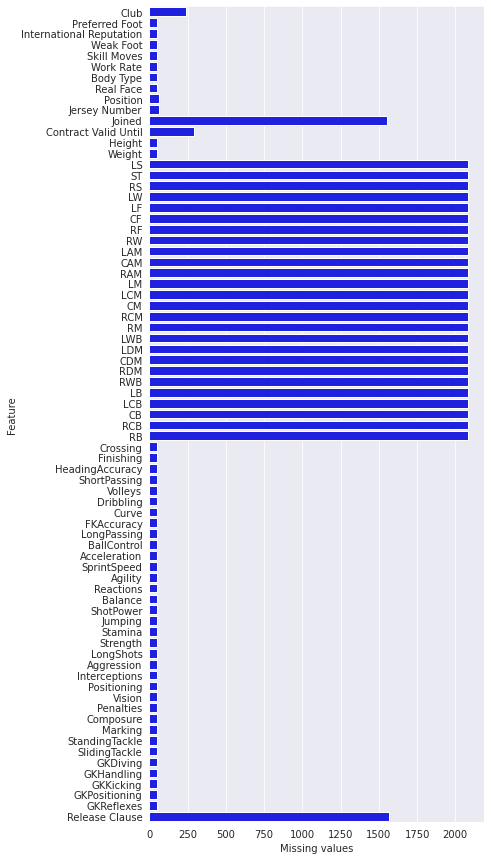

In [ ]:
f, ax = plt.subplots(figsize=(6, 15))

df_missing=pd.DataFrame.from_dict(missing_values,orient='index',columns=['Feature','Missing values'])
sns.barplot(data=df_missing,x='Missing values',y='Feature',color='b')

In [ ]:
missing_height = df[df['Height'].isnull()].index.tolist()
df.drop(df.index[missing_height],inplace =True)
df.drop(['Release Clause','Joined','Contract Valid Until'],axis=1,inplace=True)

The 2000 missing values from LS to RB are goalkeepers. We will remove them latter for ease.

#1.3) Some data visualization

In [ ]:
cols=['Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
       'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
       'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance',
       'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']
print('BEST IN DIFFERENT FIELDS :')
print('_________________________\n\n')
for i in range(len(cols)):
  print('Best player in terms of {0} is {1}'.format(cols[i],df.loc[df[cols[i]].idxmax()][2]))

BEST IN DIFFERENT FIELDS :
_________________________


Best player in terms of Crossing is Belgium
Best player in terms of Finishing is Argentina
Best player in terms of HeadingAccuracy is Brazil
Best player in terms of ShortPassing is Croatia
Best player in terms of Volleys is Uruguay
Best player in terms of Dribbling is Argentina
Best player in terms of Curve is Portugal
Best player in terms of FKAccuracy is Argentina
Best player in terms of LongPassing is Germany
Best player in terms of BallControl is Argentina
Best player in terms of Acceleration is Brazil
Best player in terms of SprintSpeed is France
Best player in terms of Agility is Brazil
Best player in terms of Reactions is Portugal
Best player in terms of Balance is Brazil
Best player in terms of ShotPower is Portugal
Best player in terms of Jumping is Portugal
Best player in terms of Stamina is France
Best player in terms of Strength is England
Best player in terms of LongShots is Argentina
Best player in terms of Aggression

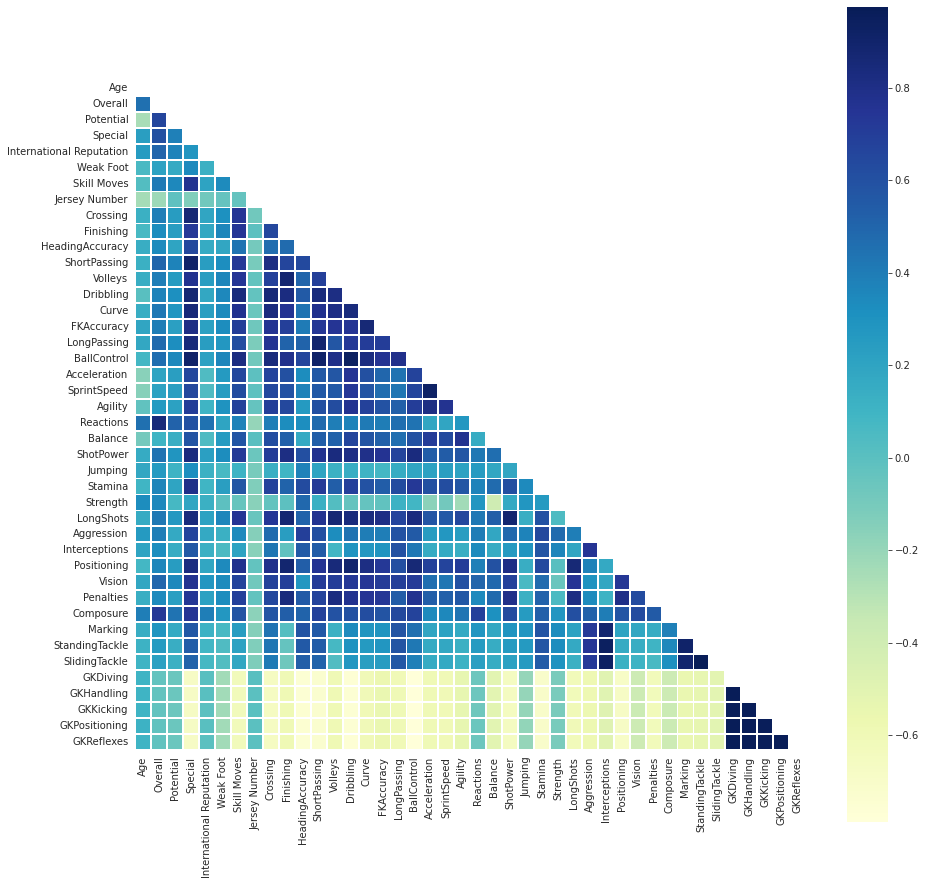

In [ ]:
correlations = df.corr()
hm = np.zeros_like(correlations)
hm[np.triu_indices_from(hm)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 15))
    ax = sns.heatmap(correlations,mask=hm,square=True,linewidths=.8,cmap="YlGnBu")

From this heatmap, we can believe that the most important features to predict overall rating will be Potential, Reactions and composure. However, we will remove the "Potential" feature as it is too much correlated to the "Overall" (it's almost the same).

#1.4) Modelling

In [ ]:
#Turn Real Face into a binary indicator variable
def face_to_num(df):
    if (df['Real Face'] == 'Yes'):
        return 1
    else:
        return 0
    
#Turn Preferred Foot into a binary indicator variable
def right_footed(df):
    if (df['Preferred Foot'] == 'Right'):
        return 1
    else:
        return 0

#Create a simplified position varaible to account for all player positions
def simple_position(df):
    if (df['Position'] == 'GK'):
        return 'GK'
    elif ((df['Position'] == 'RB') | (df['Position'] == 'LB') | (df['Position'] == 'CB') | (df['Position'] == 'LCB') | (df['Position'] == 'RCB') | (df['Position'] == 'RWB') | (df['Position'] == 'LWB') ): #the player is a defender
        return 'DF'
    elif ((df['Position'] == 'LDM') | (df['Position'] == 'CDM') | (df['Position'] == 'RDM')): #defensive midfielders
        return 'DM'
    elif ((df['Position'] == 'LM') | (df['Position'] == 'LCM') | (df['Position'] == 'CM') | (df['Position'] == 'RCM') | (df['Position'] == 'RM')): #otfher midfielders
        return 'MF'
    elif ((df['Position'] == 'LAM') | (df['Position'] == 'CAM') | (df['Position'] == 'RAM') | (df['Position'] == 'LW') | (df['Position'] == 'RW')): #wingers and attacking midfielders
        return 'AM'
    elif ((df['Position'] == 'RS') | (df['Position'] == 'ST') | (df['Position'] == 'LS') | (df['Position'] == 'CF') | (df['Position'] == 'LF') | (df['Position'] == 'RF')): #strikers and forward players
        return 'AT'
    else:
        return df.Position

#Get a count of Nationalities in the Dataset, make of list of those with over 250 Players (our Major Nations)
nat_counts = df.Nationality.value_counts()
nat_list = nat_counts[nat_counts > 250].index.tolist()

#Replace Nationality with a binary indicator variable for 'Major Nation'
def major_nation(df):
    if (df.Nationality in nat_list):
        return 1
    else:
        return 0

#Create a copy of the original dataframe to avoid indexing errors
df1 = df.copy()


#Apply changes to dataset to create new column
df1['Real_Face'] = df1.apply(face_to_num, axis=1)
df1['Right_Foot'] = df1.apply(right_footed, axis=1)
df1['Simple_Position'] = df1.apply(simple_position,axis = 1)
df1['Major_Nation'] = df1.apply(major_nation,axis = 1)
df1.drop(df1[df1.Simple_Position =='GK'].index, inplace=True)

y = pd.get_dummies(df1.Simple_Position)
df1[y.columns]=y.values

#Split the Work Rate Column in two
tempwork = df1["Work Rate"].str.split("/ ", n = 1, expand = True) 
#Work Rates are responsible to determine how often the player will defend and attack.
#Create new column for first work rate
df1["WorkRate1"]= tempwork[0].apply(lambda x : (x=='High')*2+(x=="Medium"))
#Create new column for second work rate
df1["WorkRate2"]= tempwork[1].apply(lambda x : (x=='High')*2+(x=="Medium"))

#Calculate rates for simpler data
for i in df1.loc[:,'LS':'RB'].columns:
  df1[i]=df1[i].map(lambda x : eval(x) if type(x)==str else -1)

#Convert some features from string to int
df1["Weight"]=df1["Weight"].apply(lambda x : int(x[:-3]) if type(x)==str else x)
df1['Value']=df1['Value'].apply(lambda x : float(x[1:-1])*(1000*(x[-1]=='K')+1_000_000*(x[-1]=='M')) if type(x)==str and len(x) >2 else 0 )

#Drop original columns used
df1 = df1.drop(['Work Rate','Preferred Foot','Real Face', 'Position','Nationality','Jersey Number','Simple_Position','Body Type','Name','Height','Weight','Club','Wage','GKDiving','GKHandling','GKKicking','GKPositioning','GKReflexes'], axis = 1)
df1.head()

,Age,Overall,Potential,Value,Special,International Reputation,Weak Foot,Skill Moves,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,Real_Face,Right_Foot,Major_Nation,AM,AT,DF,DM,MF,WorkRate1,WorkRate2
0,31,94,94,110500000.0,2202,5.0,4.0,4.0,90,90,90,94,95,95,95,94,95,95,95,93,86,86,86,93,66,63,63,63,66,61,49,49,49,61,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,1,0,1,0,1,0,0,0,1,1
1,33,94,94,77000000.0,2228,5.0,4.0,5.0,94,94,94,92,93,93,93,92,91,91,91,91,84,84,84,91,68,64,64,64,68,64,56,56,56,64,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,1,1,1,0,1,0,0,0,2,0
2,26,92,93,118500000.0,2143,5.0,5.0,5.0,87,87,87,92,92,92,92,92,92,92,92,91,84,84,84,91,68,63,63,63,68,63,50,50,50,63,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,1,1,1,1,0,0,0,0,2,1
4,27,91,92,102000000.0,2281,4.0,5.0,4.0,85,85,85,90,90,90,90,90,91,91,91,91,90,90,90,91,80,80,80,80,80,76,69,69,69,76,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,1,1,1,0,0,0,0,1,2,2
5,27,91,91,93000000.0,2142,4.0,4.0,4.0,86,86,86,92,91,91,91,92,92,92,92,92,85,85,85,92,69,66,66,66,69,63,52,52,52,63,81.0,84.0,61.0,89.0,80.0,95.0,83.0,79.0,83.0,94.0,94.0,88.0,95.0,90.0,94.0,82.0,56.0,83.0,66.0,80.0,54.0,41.0,87.0,89.0,86.0,91.0,34.0,27.0,22.0,1,1,1,0,1,0,0,0,2,1


In [ ]:
%%script false
from sklearn.manifold import TSNE

tsne_em = TSNE(n_iter=1000, verbose=1,perplexity=30,init='pca',learning_rate='auto').fit_transform(df1)

In [ ]:
%%script false
from matplotlib.ticker import NullFormatter

f, ax = plt.subplots(figsize=(15, 15))

ax.set_title("Perplexity")
ax.scatter(tsne_em[:, 0], tsne_em[:, 1])
#ax.scatter(tsne_em[green, 0], tsne_em[green, 1], c="g")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.axis("tight")

In [ ]:
#Split ID as a Target value
target = df1.Overall
df2 = df1.drop(['Overall','Potential'], axis = 1)

#Splitting into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df2, target, test_size=0.2)

In [ ]:
#One Hot Encoding
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
print(X_test.shape,X_train.shape)
print(y_test.shape,y_train.shape)

(3227, 71) (12907, 71)
(3227,) (12907,)


In [ ]:
X_train.head(10)

,Age,Value,Special,International Reputation,Weak Foot,Skill Moves,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,Real_Face,Right_Foot,Major_Nation,AM,AT,DF,DM,MF,WorkRate1,WorkRate2
15267,22,325000.0,1622,1.0,3.0,2.0,57,57,57,58,58,58,58,58,60,60,60,60,61,61,61,60,59,60,60,60,59,59,58,58,58,59,45.0,36.0,61.0,74.0,45.0,61.0,42.0,49.0,71.0,56.0,69.0,65.0,55.0,55.0,63.0,62.0,57.0,56.0,53.0,47.0,61.0,49.0,57.0,51.0,53.0,53.0,56.0,54.0,62.0,0,1,1,0,0,0,0,1,1,1
11371,26,475000.0,1552,1.0,2.0,2.0,51,51,51,53,53,53,53,53,55,55,55,55,57,57,57,55,60,62,62,62,60,60,64,64,64,60,40.0,34.0,55.0,57.0,27.0,53.0,23.0,31.0,52.0,59.0,62.0,59.0,65.0,61.0,66.0,41.0,71.0,63.0,73.0,46.0,64.0,62.0,45.0,52.0,36.0,51.0,72.0,61.0,56.0,0,1,1,0,0,1,0,0,1,1
8506,25,975000.0,1548,1.0,3.0,3.0,68,68,68,64,67,67,67,64,63,63,63,61,53,53,53,61,43,39,39,39,43,41,37,37,37,41,28.0,72.0,59.0,48.0,58.0,66.0,50.0,32.0,28.0,65.0,79.0,82.0,75.0,62.0,68.0,66.0,71.0,69.0,67.0,56.0,38.0,10.0,68.0,59.0,61.0,57.0,28.0,12.0,15.0,0,1,1,0,0,0,0,1,1,1
17615,19,90000.0,1387,1.0,3.0,2.0,44,44,44,46,45,45,45,46,47,47,47,48,49,49,49,48,52,53,53,53,52,52,54,54,54,52,41.0,31.0,42.0,54.0,26.0,44.0,34.0,36.0,53.0,49.0,61.0,56.0,57.0,42.0,64.0,48.0,72.0,53.0,55.0,25.0,62.0,49.0,34.0,47.0,36.0,38.0,50.0,53.0,56.0,0,1,1,0,0,0,1,0,1,1
5053,23,2500000.0,1709,1.0,3.0,3.0,66,66,66,72,70,70,70,72,71,71,71,71,65,65,65,71,56,51,51,51,56,52,44,44,44,52,72.0,64.0,46.0,67.0,58.0,75.0,52.0,61.0,58.0,70.0,77.0,74.0,80.0,66.0,77.0,65.0,62.0,65.0,57.0,67.0,34.0,30.0,65.0,70.0,54.0,62.0,40.0,28.0,24.0,0,1,1,1,0,0,0,0,1,0
9604,25,800000.0,1730,1.0,3.0,3.0,67,67,67,64,65,65,65,64,63,63,63,63,59,59,59,63,55,54,54,54,55,54,53,53,53,54,43.0,62.0,62.0,59.0,61.0,63.0,63.0,50.0,45.0,64.0,77.0,71.0,73.0,64.0,69.0,69.0,64.0,78.0,80.0,63.0,70.0,43.0,63.0,52.0,54.0,64.0,41.0,36.0,32.0,0,1,0,0,1,0,0,0,2,1
8328,19,1100000.0,1672,1.0,3.0,3.0,56,56,56,59,57,57,57,59,56,56,56,61,57,57,57,61,68,65,65,65,68,68,67,67,67,68,60.0,38.0,45.0,58.0,47.0,65.0,39.0,39.0,48.0,63.0,72.0,85.0,67.0,54.0,67.0,59.0,45.0,76.0,73.0,34.0,82.0,67.0,49.0,38.0,52.0,55.0,67.0,73.0,66.0,0,0,1,0,0,1,0,0,2,1
5622,22,2500000.0,1561,1.0,3.0,3.0,70,70,70,64,67,67,67,64,65,65,65,62,57,57,57,62,45,46,46,46,45,43,48,48,48,43,52.0,68.0,72.0,65.0,67.0,64.0,40.0,29.0,38.0,66.0,54.0,68.0,49.0,64.0,31.0,80.0,66.0,32.0,93.0,66.0,70.0,22.0,64.0,65.0,61.0,61.0,28.0,21.0,20.0,0,1,1,0,1,0,0,0,1,0
1306,31,6500000.0,1866,1.0,2.0,3.0,70,70,70,74,75,75,75,74,77,77,77,75,77,77,77,75,63,66,66,66,63,59,54,54,54,59,72.0,68.0,49.0,81.0,70.0,77.0,80.0,74.0,78.0,80.0,53.0,50.0,60.0,79.0,74.0,69.0,37.0,69.0,59.0,72.0,55.0,55.0,77.0,79.0,71.0,79.0,45.0,50.0,28.0,0,1,1,1,0,0,0,0,1,0
1494,24,8500000.0,1709,2.0,3.0,2.0,57,57,57,55,57,57,57,55,59,59,59,58,66,66,66,58,67,73,73,73,67,69,76,76,76,69,40.0,30.0,78.0,68.0,55.0,58.0,31.0,36.0,74.0,62.0,59.0,60.0,38.0,74.0,36.0,72.0,74.0,65.0,77.0,59.0,79.0,75.0,29.0,62.0,37.0,63.0,72.0,78.0,74.0,1,0,1,0,0,1,0,0,1,2


#**Part 2 - Implementation and test of different regression techniques**

#2.1) Building a linear NN with keras and SGD optimizer

The only aim of this part is to see how good we could predict the ratings of the players with a simple NN by SGD optimization. Nevertheless, we will later mainly try to predict the ratings by linear regression.

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers , Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense,Activation
from tensorflow.keras.optimizers import SGD

In [ ]:
X,y= np.array(X_train), np.array(y_train)
X_val,y_val = np.array(X_test) , np.array(y_test)

In [ ]:
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(X)

In [ ]:
print(normalizer.mean.numpy())

[[2.5026022e+01 2.5194475e+06 1.6682568e+03 1.1172236e+00 3.0065088e+00
  2.5319612e+00 5.9801342e+01 5.9801342e+01 5.9801342e+01 6.1045368e+01
  6.0725941e+01 6.0725941e+01 6.0725941e+01 6.1045368e+01 6.1003128e+01
  6.1003128e+01 6.1003128e+01 6.1756378e+01 6.0275528e+01 6.0275528e+01
  6.0275528e+01 6.1756378e+01 5.9591167e+01 5.8913864e+01 5.8913864e+01
  5.8913864e+01 5.9591167e+01 5.8891636e+01 5.7696991e+01 5.7696991e+01
  5.7696991e+01 5.8891636e+01 5.4264076e+01 4.9694927e+01 5.7046486e+01
  6.2705067e+01 4.6689064e+01 6.0615269e+01 5.1273293e+01 4.6418072e+01
  5.6210663e+01 6.3221687e+01 6.7876717e+01 6.7986519e+01 6.6440331e+01
  6.2250484e+01 6.6633728e+01 5.9633110e+01 6.5998558e+01 6.7393494e+01
  6.5862854e+01 5.1473984e+01 5.9663776e+01 5.0581478e+01 5.4817432e+01
  5.5536072e+01 5.2103619e+01 6.0373913e+01 5.1418011e+01 5.2106308e+01
  4.9816170e+01 9.3747579e-02 7.5098771e-01 7.8120458e-01 1.0846832e-01
  1.6293488e-01 3.6422089e-01 9.0725981e-02 2.7310783e-01 1.2471

In [ ]:
print(normalizer(X).numpy())

[[ 1.9698946  -0.23268695  0.5973439  ... -0.61296016 -0.450919
  -0.19245812]
 [ 0.65282345  2.3773196   0.29294717 ... -0.61296016 -0.450919
   1.6808972 ]
 [-0.44473585 -0.3781772   0.17626177 ... -0.61296016  1.3735327
   1.6808972 ]
 ...
 [-0.88375956 -0.43549153 -1.1580106  ...  1.6314287  -0.450919
  -0.19245812]
 [-1.1032715  -0.3949306  -1.3355753  ... -0.61296016 -0.450919
  -0.19245812]
 [-0.00571213 -0.40374818 -0.09262203 ... -0.61296016  1.3735327
   1.6808972 ]]


In [ ]:
print(X.shape)

(12907, 71)


In [ ]:
def build_model(units):
  model=Sequential()
  model.add(normalizer)
  model.add(Dense(units=units,input_dim=77))
  model.add(Activation('tanh'))
  model.add(Dense(units=1,input_dim=77))

  return model


sgd = SGD(learning_rate=0.001)
model=build_model(100)
model.compile(loss='mse',optimizer=sgd)
history=model.fit(X, y, verbose=1, batch_size=32,epochs=100)

Epoch 1/100
404/404 [==============================] - 1s 2ms/step - loss: 288.4654
Epoch 2/100
404/404 [==============================] - 1s 1ms/step - loss: 3.6986
Epoch 3/100
404/404 [==============================] - 1s 1ms/step - loss: 3.2341
Epoch 4/100
404/404 [==============================] - 1s 1ms/step - loss: 2.8833
Epoch 5/100
404/404 [==============================] - 1s 2ms/step - loss: 2.6447
Epoch 6/100
404/404 [==============================] - 1s 1ms/step - loss: 2.4336
Epoch 7/100
404/404 [==============================] - 1s 1ms/step - loss: 2.2981
Epoch 8/100
404/404 [==============================] - 1s 1ms/step - loss: 2.1337
Epoch 9/100
404/404 [==============================] - 1s 1ms/step - loss: 2.0001
Epoch 10/100
404/404 [==============================] - 1s 1ms/step - loss: 1.8933
Epoch 11/100
404/404 [==============================] - 1s 1ms/step - loss: 1.7844
Epoch 12/100
404/404 [==============================] - 1s 2ms/step - loss: 1.7060
Epoch 13/10

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,epoch
95,0.527079,95
96,0.525864,96
97,0.527244,97
98,0.524331,98
99,0.518752,99


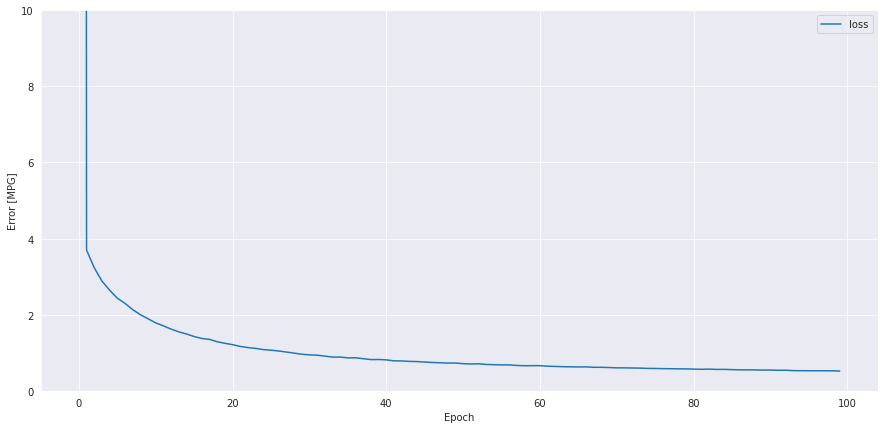

In [ ]:
f, ax = plt.subplots(figsize=(15, 7))
plt.plot(history.history['loss'], label='loss')
plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.legend()
plt.grid(True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


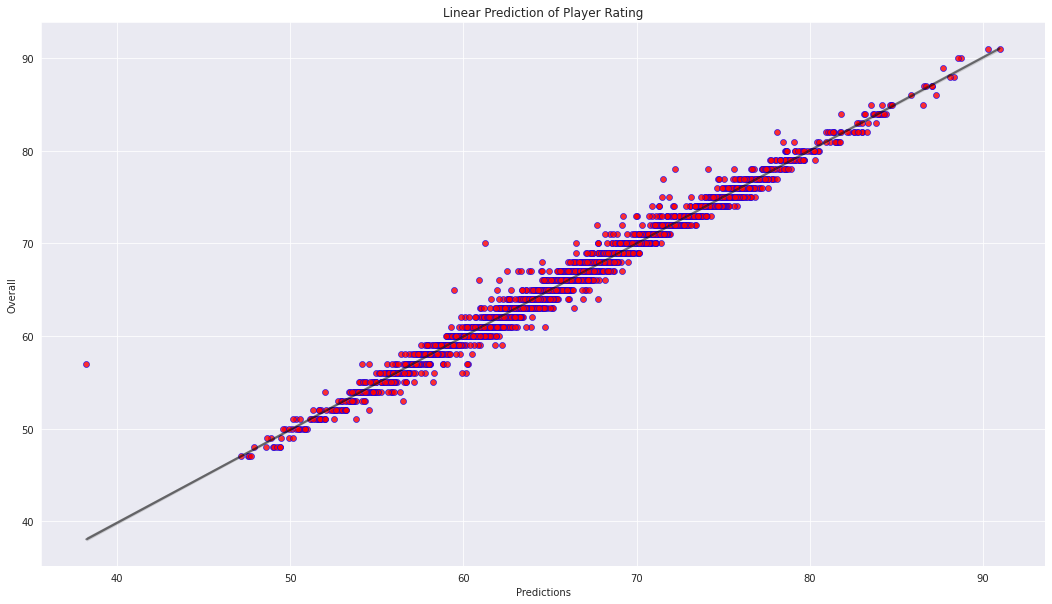

In [ ]:
predictions=model.predict(X_val)

#Visualising the results
plt.figure(figsize=(18,10))
sns.regplot(predictions,y_val,scatter_kws={'color':'red','edgecolor':'blue','linewidth':'0.7'},line_kws={'color':'black','alpha':0.5})
plt.xlabel('Predictions')
plt.ylabel('Overall')
plt.title("Linear Prediction of Player Rating")
plt.show()

#2.2) Manual linear model and batch gradient descent

For building the model and implementing a batch gradient descent, we will use and adapt the code of the numerical tour https://nbviewer.org/github/gpeyre/numerical-tours/blob/master/python/ml_6_nn.ipynb

In [ ]:
def loss(z,y): return (z-y)@(z-y).T/(y.shape[1])
def loss_gradient(z,y): return 2*(z-y)/y.shape[1]

In [ ]:
a=np.array([[1,0,1]])
b=np.array([[1,0,0]])

In [ ]:
#def loss(z,y): return 1/y.shape[1] * np.sum( np.log( 1 + np.exp(-y*z) ) )
#def loss_gradient(z,y): return -1/y.shape[1] * y * np.exp(-y*z) / ( 1 + np.exp(-y*z) )

In [ ]:
def rho(u): return np.arctan(u)
def rhoG(u): return 1/(1+u**2)

In [ ]:
X_train_norm = (X_train-X_train.min())/(X_train.max()-X_train.min())

In [ ]:
X,y= np.array(X_train_norm).T, np.array(y_train).reshape(1,-1)
X_val,y_val = np.array(X_test).T , np.array(y_test).reshape(1,-1)

In [ ]:
X.shape

(71, 12907)

In [ ]:
y=y-y.mean()

In [ ]:
p=X.shape[0]

In [ ]:
D = np.array([p,100,1]) #number of neurons for each layer
R = D.size-1 
A = []
b = [] 
for r in np.arange(0,R):
    A.append(np.random.randn(D[r+1],D[r]))
    b.append(np.random.randn(D[r+1],1))

In [ ]:
X.shape

(71, 12907)

In [ ]:
def ForwardNN(A,b,X,R):
    Xf = []
    Xf.append(X)
    for r in np.arange(0,R-1):
        Xf.append(rho(A[r]@Xf[r] + b[r]))
        #print(A[r])

    Xf.append(A[R-1]@Xf[R-1] + b[R-1])
    return Xf

In [ ]:
y_testpred = ForwardNN(A,b,X,R)
L = loss(y_testpred[-1],y)

In [ ]:
print(y_testpred[-1])

[[-4.73097067 -5.62641106 -7.77863006 ...  0.45913561 -5.57048069
  -1.57403323]]


In [ ]:
gx = loss_gradient(y_testpred[-1],y)

In [ ]:
len(X[R])

12907

In [ ]:
print(gx)

[[-0.00143675 -0.00312505 -0.00051441 ...  0.00262153  0.00044757
   0.00075693]]


In [ ]:
def BackwardNN(A,b,X,R,gx):
    gA = [] # gradient with respect to A
    gb = [] # gradient with respect to b
    n = X[0].shape[1] # number of samples in mini-batch
    for r in np.arange(0,R):
        gA.append([]) 
        gb.append([])

    M = gx
    #print(A[R-1].T.shape)
    #print(M)
    gx = (A[R-1].T) @ M
    # nabla_A[r]
    gA[R-1] =  M @ (X[R-1].T)
    # nabla_b[r]
    gb[R-1] =  (M.sum(axis=1)).reshape(-1,1)
    for r in np.arange(R-2,-1,-1):
        M = rhoG( (A[r] @ X[r]) +b[r] ) * gx
        # nabla_X[r]
        gx = (A[r].T) @ M
        # nabla_A[r]
        gA[r] =  M @ (X[r].T)
        # nabla_b[r]
        gb[r] =  (M.sum(axis=1)).reshape(-1,1)
    return [gA,gb]

def ForwardBackwardNN(A,b,x,y):
    ## forward pass
    Xf = ForwardNN(A,b,x,R)
    #print(Xf[R])
    L = loss(Xf[-1],y)
    gx = loss_gradient(Xf[-1],y) # initialize the gradient
    [gA,gb] = BackwardNN(A,b,Xf,R,gx)
    return [L,gA,gb,Xf[-1]]

In [ ]:
for r in np.arange(0,R):
    A[r] = np.random.randn(D[r+1],D[r])
    b[r] = np.random.randn(D[r+1],1)

In [ ]:
lr = .001

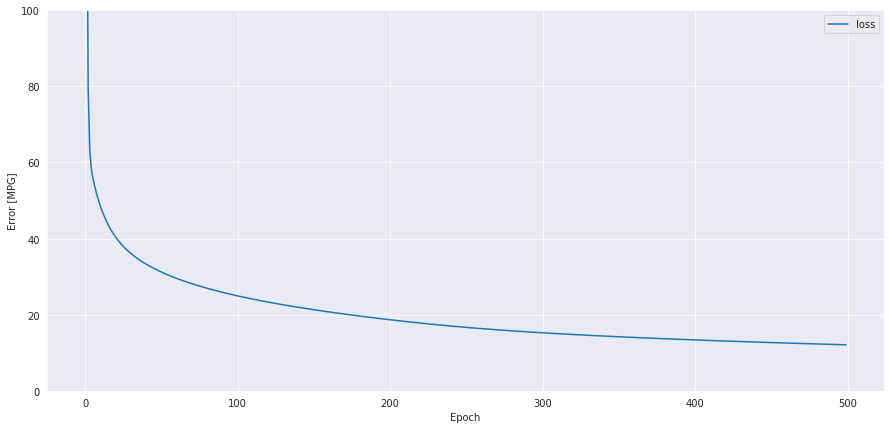

In [ ]:
niter = 500
L = np.zeros((niter,1))
for it in np.arange(0,niter):
    [L[it],gA,gb,pred] = ForwardBackwardNN(A,b,X,y)
    for r in np.arange(0,R):
        A[r] = A[r] - lr*gA[r]
        b[r] = b[r] - lr*gb[r]


f, ax = plt.subplots(figsize=(15, 7))
plt.plot(L, label='loss')
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.legend()
plt.grid(True)

In [ ]:
import autograd.numpy as np
import autograd as ag
from autograd import elementwise_grad as egrad

In [ ]:
def FuncNN(theta): 
    x = ForwardNN(theta[0],theta[1],X,R)
    return loss(x[-1],y)

In [ ]:
FuncNNG = ag.value_and_grad(FuncNN)
#X = ForwardNN(A,b,x,R)
#FuncNN((A,b))
[u,g] = FuncNNG((A,b))
gA = g[0] # gradient with respect to A 
gb = g[1] # gradient with respect to b

In [ ]:
[L,gA1,gb1,pred] = ForwardBackwardNN(A,b,X,y)
R = np.size(A)
e = 0
for i in range(R):
    e += np.linalg.norm(gA[r]-gA1[r])
    e += np.linalg.norm(gb[r]-gb1[r])
print('Should be 0:' + str(e))

Should be 0:8.13864959376349e-16


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


#2.3) Linear Regression

In this part, we look for an approximation $y_i \approx <x,a_i>$ written in matrix format $y= A x$. All the code is adapted from the Jupyter Notebook obtained [here](https://www.lamsade.dauphine.fr/~croyer/ensdocs/SG/SourcesLabSG01.zip) of Clément Royer.

In order to speed up the processes, we will mainly focus on FIFA position features

In [ ]:
df1.head()

,Age,Overall,Potential,Value,Special,International Reputation,Weak Foot,Skill Moves,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,Real_Face,Right_Foot,Major_Nation,AM,AT,DF,DM,MF,WorkRate1,WorkRate2
0,31,94,94,110500000.0,2202,5.0,4.0,4.0,90,90,90,94,95,95,95,94,95,95,95,93,86,86,86,93,66,63,63,63,66,61,49,49,49,61,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,1,0,1,0,1,0,0,0,1,1
1,33,94,94,77000000.0,2228,5.0,4.0,5.0,94,94,94,92,93,93,93,92,91,91,91,91,84,84,84,91,68,64,64,64,68,64,56,56,56,64,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,1,1,1,0,1,0,0,0,2,0
2,26,92,93,118500000.0,2143,5.0,5.0,5.0,87,87,87,92,92,92,92,92,92,92,92,91,84,84,84,91,68,63,63,63,68,63,50,50,50,63,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,1,1,1,1,0,0,0,0,2,1
4,27,91,92,102000000.0,2281,4.0,5.0,4.0,85,85,85,90,90,90,90,90,91,91,91,91,90,90,90,91,80,80,80,80,80,76,69,69,69,76,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,1,1,1,0,0,0,0,1,2,2
5,27,91,91,93000000.0,2142,4.0,4.0,4.0,86,86,86,92,91,91,91,92,92,92,92,92,85,85,85,92,69,66,66,66,69,63,52,52,52,63,81.0,84.0,61.0,89.0,80.0,95.0,83.0,79.0,83.0,94.0,94.0,88.0,95.0,90.0,94.0,82.0,56.0,83.0,66.0,80.0,54.0,41.0,87.0,89.0,86.0,91.0,34.0,27.0,22.0,1,1,1,0,1,0,0,0,2,1


In [ ]:
#Split ID as a Target value
target = df1.Overall
df3 = df1.drop(['Age','Overall','Potential','Value','Special','International Reputation','Weak Foot','Skill Moves','Real_Face','Right_Foot','Major_Nation','WorkRate1','WorkRate2'], axis = 1)
for i in df3.loc[:,'Crossing':'SlidingTackle'].columns:
  df3= df3.drop([i],axis=1)

#Splitting into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df3, target, test_size=0.2)

In [ ]:
df3.head()

,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,AM,AT,DF,DM,MF
0,90,90,90,94,95,95,95,94,95,95,95,93,86,86,86,93,66,63,63,63,66,61,49,49,49,61,0,1,0,0,0
1,94,94,94,92,93,93,93,92,91,91,91,91,84,84,84,91,68,64,64,64,68,64,56,56,56,64,0,1,0,0,0
2,87,87,87,92,92,92,92,92,92,92,92,91,84,84,84,91,68,63,63,63,68,63,50,50,50,63,1,0,0,0,0
4,85,85,85,90,90,90,90,90,91,91,91,91,90,90,90,91,80,80,80,80,80,76,69,69,69,76,0,0,0,0,1
5,86,86,86,92,91,91,91,92,92,92,92,92,85,85,85,92,69,66,66,66,69,63,52,52,52,63,0,1,0,0,0


In [ ]:
#One Hot Encoding
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
print(X_test.shape,X_train.shape)
print(y_test.shape,y_train.shape)

(3227, 31) (12907, 31)
(3227,) (12907,)


In [ ]:
#import numba
#from numba import njit, jit, jitclass  # A just in time compiler to accelerate the calculation
#from numba import int32, float32 

from math import sqrt # Square root

# NumPy - Matrix and vector structures
import numpy as np # NumPy library
from numpy.random import multivariate_normal, randn # Probability distributions on vectors
# SciPy - Efficient mathematical calculation
from scipy.linalg.special_matrices import toeplitz # A special kind of matrices
from scipy.linalg import svdvals # Singular values
from scipy.linalg import norm # Euclidean norm
from scipy.optimize import check_grad # Check accuracy between objective and gradient values
from scipy.optimize import fmin_l_bfgs_b # Efficient optimizer

In [ ]:
X_train_norm = (X_train-X_train.min())/(X_train.max()-X_train.min())

In [ ]:
X,y= np.array(X_train_norm), np.array(y_train)
X_val,y_val = np.array(X_test), np.array(y_test)

Here we remove one value to the train dataset for SGD algorithm with mini-batch to work (otherwise n is prime and it doesn't enter in the (k*nb)%n blocks)

In [ ]:
X=X[:-1]

In [ ]:
y=y-y.mean()
y=y[:-1]

In [ ]:
# Python class for regression problems
#spec=[('X',numba.typeof(X)),('y',numba.typeof(y)),('lbda',int32),('loss',numba.typeof('l2'))]
#@jitclass(spec)
class RegPb(object):
    '''
        A class for regression problems with linear models.
        
        Attributes:
            X: Data matrix (features)
            y: Data vector (labels)
            n,d: Dimensions of X
            loss: Loss function to be considered in the regression
                'l2': Least-squares loss
                'logit': Logistic loss
            lbda: Regularization parameter
    '''
   
    # Instantiate the class
    def __init__(self, X, y,lbda=0,loss='l2'):
        self.X = X
        self.y = y
        self.n, self.d = X.shape
        self.loss = loss
        self.lbda = lbda
        
    # Objective value
    def fun(self, w):
      return np.linalg.norm(self.X.dot(w) - self.y) ** 2 / (2. * self.n) + self.lbda * np.linalg.norm(w) ** 2 / 2.

    # Partial objective value
    def f_i(self, i, w):
      return np.linalg.norm(self.X[i].dot(w) - self.y[i]) ** 2 / (2.) + self.lbda * np.linalg.norm(w) ** 2 / 2.
    
    # Full gradient computation
    def grad(self, w):
      return self.X.T.dot(self.X.dot(w) - self.y) / self.n + self.lbda * w

    # Partial gradient
    def grad_i(self,i,w):
        x_i = self.X[i]
        return (x_i.dot(w) - self.y[i]) * x_i + self.lbda*w

    # Lipschitz constant for the gradient
    def lipgrad(self):
      L = np.linalg.norm(self.X, ord=2) ** 2 / self.n + self.lbda
      return L

    # ''Strong'' convexity constant (could be zero if self.lbda=0)
    def cvxval(self):
      s = svdvals(self.X)
      mu = min(s)**2 / self.n 
      return mu + self.lbda

In [ ]:
pblinreg = RegPb(X, y,loss='l2')
d=X.shape[1]

In [ ]:
w_init = np.random.rand(d)
# Compute the optimal solution for linear regression
w_min_lin, f_min_lin, _ = fmin_l_bfgs_b(pblinreg.fun, w_init, pblinreg.grad, args=(), pgtol=1e-30, factr =1e-30)
print(f_min_lin)
print(norm(pblinreg.grad(w_min_lin)))

5.075055601039992
1.1662197731207061e-07


In [ ]:
X_val,y_val=(X_val-X_val.min())/(X_val.max()-X_val.min()),y_val-y.mean()

In [ ]:
tau = 1/np.linalg.norm(X,2)**2

In [ ]:
print(check_grad(pblinreg.fun, pblinreg.grad, np.random.randn(d)))
grad_error = []
for i in range(n):
    ind = np.random.choice(n,1)
    w =  np.random.randn(d)
    vec =  np.random.randn(d)
    eps = pow(10.0, -7.0)
    grad_error.append((pblinreg.f_i( ind[0], w+eps*vec) - pblinreg.f_i( ind[0], w))/eps - np.dot(pblinreg.grad_i(ind[0],w),vec)) 
print(np.mean(grad_error))

2.6423761128775283e-06
6.336774698974937e-07


In [ ]:
# Stochastic gradient implementation
def stoch_grad(w0,problem,wtarget,stepchoice=0,step0=1, n_iter=1000,nb=1,with_replace=False,verbose=True): 
    """
        A code for gradient descent with various step choices.
        
        Inputs:
            w0: Initial vector
            problem: Problem structure
                problem.fun() returns the objective function, which is assumed to be a finite sum of functions
                problem.n returns the number of components in the finite sum
                problem.grad_i() returns the gradient of a single component f_i
                problem.lipgrad() returns the Lipschitz constant for the gradient
                problem.cvxval() returns the strong convexity constant
                problem.lambda returns the value of the regularization parameter
            wtarget: Target minimum (unknown in practice!)
            stepchoice: Strategy for computing the stepsize 
                0: Constant step size equal to 1/L
                t>0: Step size decreasing in 1/(k+1)**t
            step0: Initial steplength (only used when stepchoice is not 0)
            n_iter: Number of iterations, used as stopping criterion
            nb: Number of components drawn per iteration/Batch size 
                1: Classical stochastic gradient algorithm (default value)
            with_replace: Boolean indicating whether components are drawn with or without replacement
                True: Components drawn with replacement
                False: Components drawn without replacement (Default)
            verbose: Boolean indicating whether information should be plot at every iteration (Default: False)
            
        Outputs:
            w_output: Final iterate of the method (or average if average=1)
            objvals: History of function values (Numpy array of length n_iter at most)
            normits: History of distances between iterates and optimum (Numpy array of length n_iter at most)
    """
    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []
    
    # iterates distance to the minimum history
    normits = []
    
    # Lipschitz constant
    L = problem.lipgrad()
    
    # Number of samples
    n = problem.n
    
    # Initial value of current iterate  
    w = w0.copy()
    nw = norm(w)

    # Initialize iteration counter
    k=0
    
    # Current objective
    obj = problem.fun(w) 
    objvals.append(obj);
    # Current distance to the optimum
    nmin = norm(w-wtarget)
    normits.append(nmin)
    
    if verbose:
        # Plot initial quantities of interest
        print("Stochastic Gradient, batch size=",nb,"/",n)
        print(' | '.join([name.center(8) for name in ["iter", "fval", "normit"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))
    
    ################
    # Main loop
    while (k < n_iter and nw < 10**100):
        # Draw the batch indices
        ik = np.random.choice(n,nb,replace=with_replace)# Batch gradient
        # Stochastic gradient calculation
        sg = np.zeros(d)
        for j in range(nb):
            gi = problem.grad_i(ik[j],w)
            sg = sg + gi
        sg = (1/nb)*sg
            
        if stepchoice==0:
            w[:] = w - (step0/L) * sg
        elif stepchoice>0:
            sk = float(step0/((k+1)**stepchoice))
            w[:] = w - sk * sg
        
        #print(w)
        
        nw = norm(w) #Computing the norm to measure divergence 

        obj = problem.fun(w)
        nmin = norm(w-wtarget)
        
        k += 1
        # Plot quantities of interest at the end of every epoch only
        if (k*nb) % n == 0:
            objvals.append(obj)
            normits.append(nmin)
            if verbose:
                print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))       
    
    # End of main loop
    #################
    
    # Plot quantities of interest for the last iterate (if needed)
    if (k*nb) % n > 0:
        objvals.append(obj)
        normits.append(nmin)
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))              
    
    # Outputs
    w_output = w.copy()
    
    return w_output, np.array(objvals), np.array(normits)

In [ ]:
nb_epochs = 100
n = pblinreg.n
w0 = np.random.rand(d)

start_time = time.time()
# Run a - Gradient descent with constant stepsize
w_a, obj_a, nits_a = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0,step0=1, n_iter=nb_epochs,nb=n)

print("--- %s minutes ---" % ((time.time() - start_time)/60))

start_time = time.time()
# Run b - Stochastic gradient with constant stepsize
# The version below may diverges, in which case the bound on norm(w) in the code will be triggered
w_b, obj_b, nits_b = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0,step0=1, n_iter=int(nb_epochs*n),nb=1)
print("--- %s minutes ---" % ((time.time() - start_time)/60))

start_time = time.time()
# Run Stochastic gradient with decreasing stepsize
w_c, obj_c, nits_c = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=nb_epochs*n,nb=1)
print("--- %s minutes ---" % ((time.time() - start_time)/60))

Stochastic Gradient, batch size= 12907 / 12907
  iter   |   fval   |  normit 
       0 | 5.66e+01 | 1.49e+02
       1 | 2.31e+01 | 1.49e+02
       2 | 2.31e+01 | 1.49e+02
       3 | 2.31e+01 | 1.49e+02
       4 | 2.30e+01 | 1.49e+02
       5 | 2.30e+01 | 1.49e+02
       6 | 2.30e+01 | 1.49e+02
       7 | 2.30e+01 | 1.49e+02
       8 | 2.30e+01 | 1.49e+02
       9 | 2.30e+01 | 1.49e+02
      10 | 2.30e+01 | 1.49e+02
      11 | 2.30e+01 | 1.49e+02
      12 | 2.29e+01 | 1.49e+02
      13 | 2.29e+01 | 1.49e+02
      14 | 2.29e+01 | 1.49e+02
      15 | 2.29e+01 | 1.49e+02
      16 | 2.29e+01 | 1.49e+02
      17 | 2.29e+01 | 1.49e+02
      18 | 2.29e+01 | 1.49e+02
      19 | 2.29e+01 | 1.49e+02
      20 | 2.29e+01 | 1.49e+02
      21 | 2.28e+01 | 1.49e+02
      22 | 2.28e+01 | 1.49e+02
      23 | 2.28e+01 | 1.49e+02
      24 | 2.28e+01 | 1.49e+02
      25 | 2.28e+01 | 1.49e+02
      26 | 2.28e+01 | 1.49e+02
      27 | 2.28e+01 | 1.49e+02
      28 | 2.28e+01 | 1.49e+02
      29 | 2.28e+01 | 1

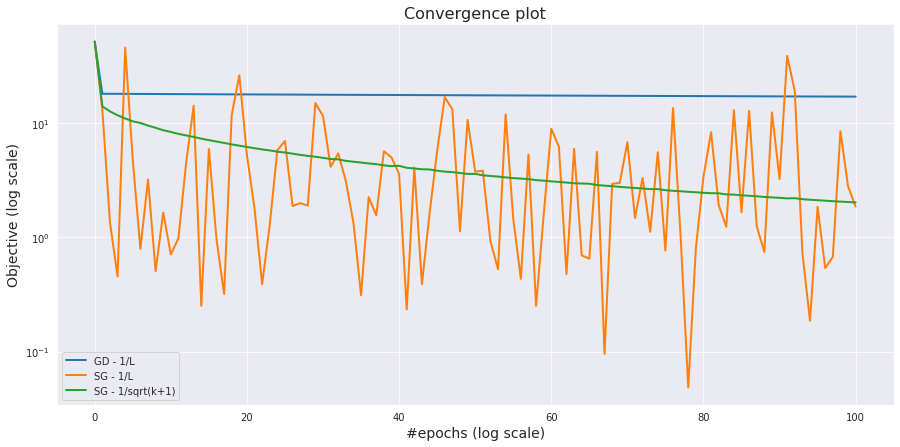

In [ ]:
# Plot the comparison of variants of GD/SG with the same stepsize rule
# NB: The x-axis is in epochs (1 iteration of GD).

# In terms of objective value (logarithmic scale)
f, ax = plt.subplots(figsize=(15, 7))
plt.semilogy(obj_a-f_min_lin, label="GD - 1/L", lw=2)
plt.semilogy(obj_b-f_min_lin, label="SG - 1/L", lw=2)
plt.semilogy(obj_c-f_min_lin, label="SG - 1/sqrt(k+1)", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()

#2.3.1) Experimenting with the step size for batch gradient descent

*Implementation: Run several instances of standard gradient descent with constant step size proportional to $\frac{1}{L}$ (use the* step0 *parameter from the code). Compare the plots.*

In [ ]:
# Run several instances of stochastic gradient with constant batch size

nb_epochs = 100
n = pblinreg.n
nbset = 1
w0 = np.zeros(d)

valsstep0 = [1,0.1,0.01,0.001,0.0001]
nvals = len(valsstep0)

objs = np.zeros((nb_epochs+1,nvals))

for val in range(nvals):
    _, objs[:,val], _ = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0,step0=valsstep0[val], n_iter=nb_epochs,nb=n)


Stochastic Gradient, batch size= 12907 / 12907
  iter   |   fval   |  normit 
       0 | 2.30e+01 | 1.45e+02
       1 | 2.27e+01 | 1.45e+02
       2 | 2.27e+01 | 1.45e+02
       3 | 2.27e+01 | 1.45e+02
       4 | 2.27e+01 | 1.45e+02
       5 | 2.27e+01 | 1.45e+02
       6 | 2.27e+01 | 1.45e+02
       7 | 2.27e+01 | 1.45e+02
       8 | 2.26e+01 | 1.45e+02
       9 | 2.26e+01 | 1.45e+02
      10 | 2.26e+01 | 1.45e+02
      11 | 2.26e+01 | 1.45e+02
      12 | 2.26e+01 | 1.45e+02
      13 | 2.26e+01 | 1.45e+02
      14 | 2.26e+01 | 1.45e+02
      15 | 2.26e+01 | 1.45e+02
      16 | 2.25e+01 | 1.45e+02
      17 | 2.25e+01 | 1.45e+02
      18 | 2.25e+01 | 1.45e+02
      19 | 2.25e+01 | 1.45e+02
      20 | 2.25e+01 | 1.45e+02
      21 | 2.25e+01 | 1.45e+02
      22 | 2.25e+01 | 1.45e+02
      23 | 2.25e+01 | 1.45e+02
      24 | 2.24e+01 | 1.45e+02
      25 | 2.24e+01 | 1.45e+02
      26 | 2.24e+01 | 1.45e+02
      27 | 2.24e+01 | 1.45e+02
      28 | 2.24e+01 | 1.45e+02
      29 | 2.24e+01 | 1

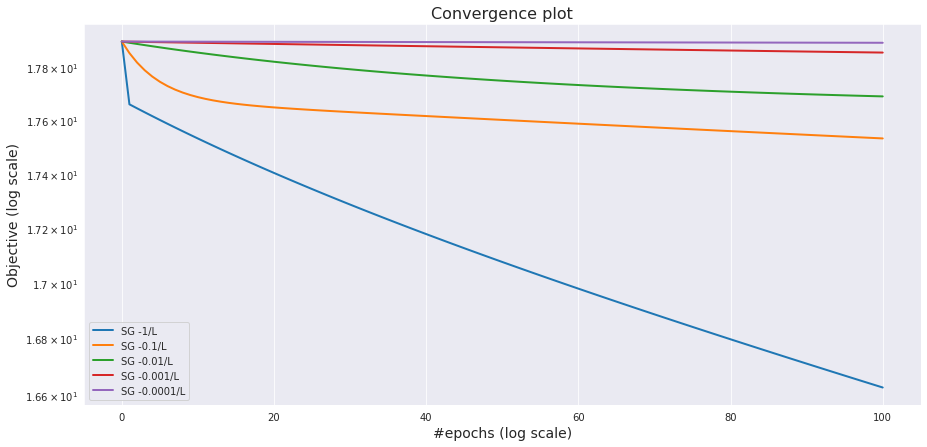

In [ ]:
# Plot the comparison of variants of SG with different (constant) stepsizes
# NB: The x-axis is in epochs (1 iteration of GD).

# In terms of objective value (logarithmic scale)
f, ax = plt.subplots(figsize=(15, 7))
plt.set_cmap("RdPu")
for val in range(nvals):
    plt.semilogy(objs[:,val]-f_min_lin, label="SG -"+str(valsstep0[val])+"/L", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()

*Implementation: Run stochastic gradient with variants of decreasing stepsizes. Select a constant $\alpha_0$ and 
compare $\alpha_0/\sqrt{k+1}$, $\alpha_0/(k+1)$, $\alpha_0/(k+1)^{1/4}$, $\alpha_0/(k+1)^{2/3}$.*

In [ ]:
# Run several instances of stochastic gradient with constant batch size

nb_epochs = 100
n = pblinreg.n
nbset = 1
w0 = np.zeros(d)

decstep = [1,2/3,1/2,1/4,0]
nvals = len(decstep)

objs = np.zeros((nb_epochs+1,nvals))

for val in range(nvals):
    _, objs[:,val], _ = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=decstep[val],step0=0.2, n_iter=nb_epochs,nb=n)




Stochastic Gradient, batch size= 12907 / 12907
  iter   |   fval   |  normit 
       0 | 2.30e+01 | 1.45e+02
       1 | 2.31e+01 | 1.45e+02
       2 | 2.27e+01 | 1.45e+02
       3 | 2.27e+01 | 1.45e+02
       4 | 2.27e+01 | 1.45e+02
       5 | 2.27e+01 | 1.45e+02
       6 | 2.27e+01 | 1.45e+02
       7 | 2.27e+01 | 1.45e+02
       8 | 2.27e+01 | 1.45e+02
       9 | 2.27e+01 | 1.45e+02
      10 | 2.27e+01 | 1.45e+02
      11 | 2.27e+01 | 1.45e+02
      12 | 2.27e+01 | 1.45e+02
      13 | 2.27e+01 | 1.45e+02
      14 | 2.27e+01 | 1.45e+02
      15 | 2.27e+01 | 1.45e+02
      16 | 2.26e+01 | 1.45e+02
      17 | 2.26e+01 | 1.45e+02
      18 | 2.26e+01 | 1.45e+02
      19 | 2.26e+01 | 1.45e+02
      20 | 2.26e+01 | 1.45e+02
      21 | 2.26e+01 | 1.45e+02
      22 | 2.26e+01 | 1.45e+02
      23 | 2.26e+01 | 1.45e+02
      24 | 2.26e+01 | 1.45e+02
      25 | 2.26e+01 | 1.45e+02
      26 | 2.26e+01 | 1.45e+02
      27 | 2.26e+01 | 1.45e+02
      28 | 2.26e+01 | 1.45e+02
      29 | 2.26e+01 | 1

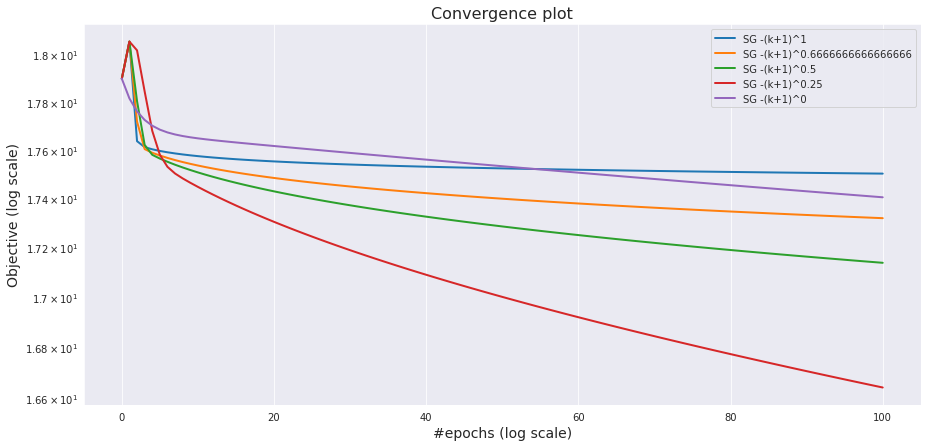

In [ ]:
# Plot the comparison of variants of SG with different (constant) stepsizes
# NB: The x-axis is in epochs (1 iteration of GD).

# In terms of objective value (logarithmic scale)
f, ax = plt.subplots(figsize=(15, 7))
plt.set_cmap("RdPu")
for val in range(nvals):
    plt.semilogy(objs[:,val]-f_min_lin, label="SG -(k+1)^"+str(decstep[val]), lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend(loc=1)

#2.3.2) Experimenting with the step size for stochastic gradient descent

*Implementation: Run several instances of standard stochastic gradient with constant step size proportional to $\frac{1}{L}$ (use the* step0 *parameter from the code). Compare the plots.*

In [ ]:
# Run several instances of stochastic gradient with constant batch size

nb_epochs = 100
n = pblinreg.n
nbset = 1
w0 = np.zeros(d)

valsstep0 = [1,0.1,0.01,0.001,0.0001]
nvals = len(valsstep0)

objs = np.zeros((nb_epochs+1,nvals))

for val in range(nvals):
    _, objs[:,val], _ = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0,step0=valsstep0[val], n_iter=int(nb_epochs*n/nbset),nb=1)


Stochastic Gradient, batch size= 1 / 12907
  iter   |   fval   |  normit 
       0 | 2.30e+01 | 1.45e+02
   12907 | 6.09e+00 | 8.27e+01
   25814 | 7.57e+00 | 7.73e+01
   38721 | 2.80e+01 | 7.35e+01
   51628 | 7.20e+00 | 6.99e+01
   64535 | 2.62e+01 | 6.62e+01
   77442 | 6.82e+00 | 6.30e+01
   90349 | 6.47e+00 | 6.03e+01
  103256 | 2.57e+01 | 5.77e+01
  116163 | 3.56e+01 | 5.52e+01
  129070 | 5.83e+00 | 5.31e+01
  141977 | 9.92e+00 | 5.10e+01
  154884 | 1.08e+01 | 4.86e+01
  167791 | 2.78e+01 | 4.65e+01
  180698 | 9.43e+00 | 4.53e+01
  193605 | 1.17e+01 | 4.34e+01
  206512 | 8.47e+00 | 4.14e+01
  219419 | 7.17e+00 | 4.01e+01
  232326 | 5.37e+00 | 3.83e+01
  245233 | 1.42e+01 | 3.68e+01
  258140 | 5.61e+00 | 3.57e+01
  271047 | 8.45e+00 | 3.43e+01
  283954 | 9.81e+00 | 3.31e+01
  296861 | 2.18e+01 | 3.19e+01
  309768 | 6.23e+00 | 3.07e+01
  322675 | 5.81e+00 | 2.99e+01
  335582 | 7.69e+00 | 2.84e+01
  348489 | 2.18e+01 | 2.76e+01
  361396 | 7.25e+00 | 2.64e+01
  374303 | 2.58e+01 | 2.58e

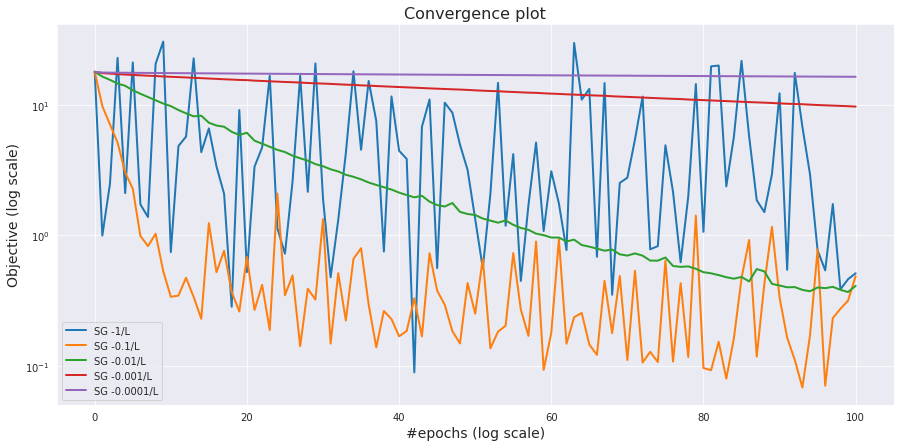

In [ ]:
# Plot the comparison of variants of SG with different (constant) stepsizes
# NB: The x-axis is in epochs (1 iteration of GD).

# In terms of objective value (logarithmic scale)
f, ax = plt.subplots(figsize=(15, 7))
plt.set_cmap("RdPu")
for val in range(nvals):
    plt.semilogy(objs[:,val]-f_min_lin, label="SG -"+str(valsstep0[val])+"/L", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()

*Implementation: Run stochastic gradient with variants of decreasing stepsizes. Select a constant $\alpha_0$ and 
compare $\alpha_0/\sqrt{k+1}$, $\alpha_0/(k+1)$, $\alpha_0/(k+1)^{1/4}$, $\alpha_0/(k+1)^{2/3}$.*

In [ ]:
# Run several instances of stochastic gradient with constant batch size

nb_epochs = 100
n = pblinreg.n
nbset = 1
w0 = np.zeros(d)

decstep = [1,2/3,1/2,1/4,0]
nvals = len(decstep)

objs = np.zeros((nb_epochs+1,nvals))

for val in range(nvals):
    _, objs[:,val], _ = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=decstep[val],step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=1)




Stochastic Gradient, batch size= 1 / 12907
  iter   |   fval   |  normit 
       0 | 2.30e+01 | 1.45e+02
   12907 | 2.25e+01 | 1.45e+02
   25814 | 2.25e+01 | 1.45e+02
   38721 | 2.25e+01 | 1.45e+02
   51628 | 2.25e+01 | 1.45e+02
   64535 | 2.25e+01 | 1.45e+02
   77442 | 2.25e+01 | 1.45e+02
   90349 | 2.25e+01 | 1.45e+02
  103256 | 2.25e+01 | 1.45e+02
  116163 | 2.24e+01 | 1.45e+02
  129070 | 2.24e+01 | 1.45e+02
  141977 | 2.24e+01 | 1.45e+02
  154884 | 2.24e+01 | 1.45e+02
  167791 | 2.24e+01 | 1.45e+02
  180698 | 2.24e+01 | 1.45e+02
  193605 | 2.24e+01 | 1.45e+02
  206512 | 2.24e+01 | 1.45e+02
  219419 | 2.24e+01 | 1.45e+02
  232326 | 2.24e+01 | 1.45e+02
  245233 | 2.24e+01 | 1.45e+02
  258140 | 2.24e+01 | 1.45e+02
  271047 | 2.24e+01 | 1.45e+02
  283954 | 2.24e+01 | 1.45e+02
  296861 | 2.24e+01 | 1.45e+02
  309768 | 2.24e+01 | 1.45e+02
  322675 | 2.24e+01 | 1.45e+02
  335582 | 2.24e+01 | 1.45e+02
  348489 | 2.24e+01 | 1.45e+02
  361396 | 2.24e+01 | 1.45e+02
  374303 | 2.24e+01 | 1.45e

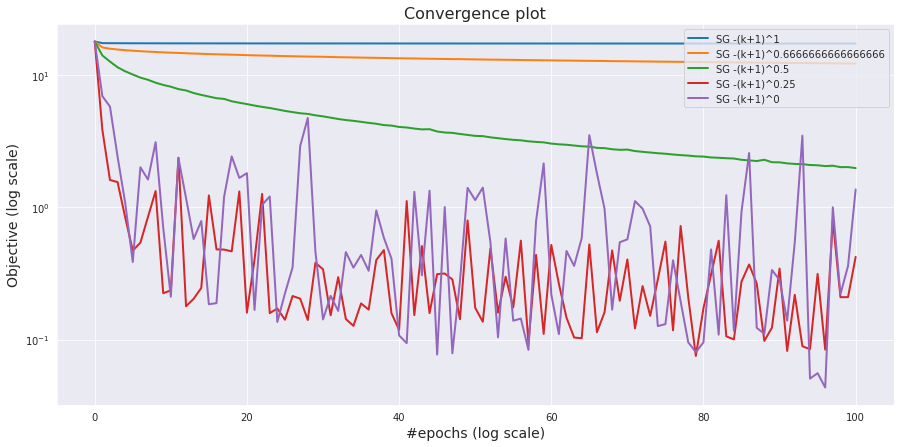

In [ ]:
# Plot the comparison of variants of SG with different (constant) stepsizes
# NB: The x-axis is in epochs (1 iteration of GD).

# In terms of objective value (logarithmic scale)
f, ax = plt.subplots(figsize=(15, 7))
plt.set_cmap("RdPu")
for val in range(nvals):
    plt.semilogy(objs[:,val]-f_min_lin, label="SG -(k+1)^"+str(decstep[val]), lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend(loc=1)

 # 2.3.3) Experimenting with the batch size

**Experimentation:** Compare the performance of stochastic gradient with several values for the batch size (and using decreasing stepsizes) to include stochastic gradient ($n_b=1$) and gradient descent ($n_b=n$).

In [ ]:
# Test several values for the batch size using the same epoch budget.

nb_epochs = 100
n = pblinreg.n
w0 = np.zeros(d)

replace_batch=False

# Stochastic gradient (batch size 1)
w_a, obj_a, nits_a = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=nb_epochs*n,nb=1)
# Batch stochastic gradient (batch size n/100)
nbset=int(n/239)
w_b, obj_b, nits_b = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=nbset,with_replace=replace_batch)
# Batch stochastic gradient (batch size n/10)
nbset=int(n/54)
w_c, obj_c, nits_c = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=nbset,with_replace=replace_batch)
# Batch stochastic gradient (batch size n/2)
nbset=int(n/18)
w_d, obj_d, nits_d = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=nbset,with_replace=replace_batch)

# Gradient descent (batch size n, taken without replacement)
w_f, obj_f, nits_f = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=int(nb_epochs),nb=n)

Stochastic Gradient, batch size= 1 / 12906
  iter   |   fval   |  normit 
       0 | 2.33e+01 | 1.49e+02
   12906 | 1.90e+01 | 1.39e+02
   25812 | 1.74e+01 | 1.35e+02
   38718 | 1.65e+01 | 1.32e+02
   51624 | 1.58e+01 | 1.30e+02
   64530 | 1.52e+01 | 1.28e+02
   77436 | 1.47e+01 | 1.27e+02
   90342 | 1.42e+01 | 1.26e+02
  103248 | 1.38e+01 | 1.24e+02
  116154 | 1.36e+01 | 1.23e+02
  129060 | 1.32e+01 | 1.22e+02
  141966 | 1.29e+01 | 1.21e+02
  154872 | 1.26e+01 | 1.21e+02
  167778 | 1.25e+01 | 1.20e+02
  180684 | 1.22e+01 | 1.19e+02
  193590 | 1.20e+01 | 1.18e+02
  206496 | 1.18e+01 | 1.18e+02
  219402 | 1.16e+01 | 1.17e+02
  232308 | 1.14e+01 | 1.16e+02
  245214 | 1.13e+01 | 1.16e+02
  258120 | 1.11e+01 | 1.15e+02
  271026 | 1.10e+01 | 1.15e+02
  283932 | 1.09e+01 | 1.14e+02
  296838 | 1.07e+01 | 1.14e+02
  309744 | 1.05e+01 | 1.13e+02
  322650 | 1.04e+01 | 1.13e+02
  335556 | 1.03e+01 | 1.13e+02
  348462 | 1.02e+01 | 1.12e+02
  361368 | 1.01e+01 | 1.12e+02
  374274 | 1.00e+01 | 1.11e

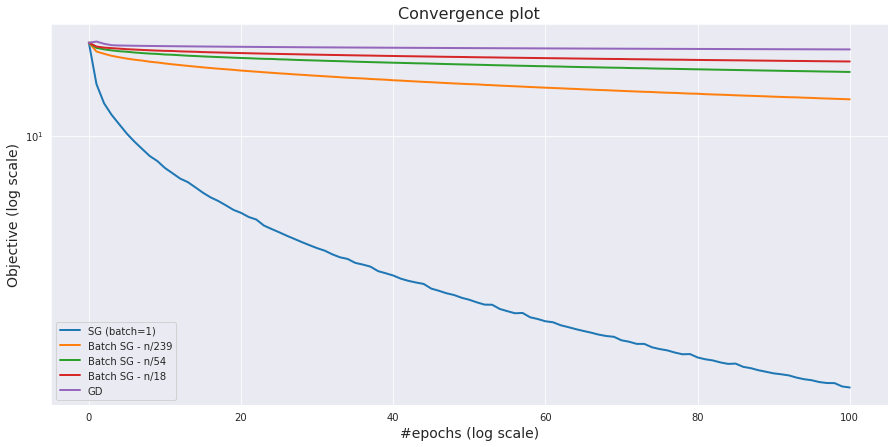

In [ ]:
# In terms of objective value (logarithmic scale)
f, ax = plt.subplots(figsize=(15, 7))
plt.semilogy(obj_a-f_min_lin, label="SG (batch=1)", lw=2)
plt.semilogy(obj_b-f_min_lin, label="Batch SG - n/239", lw=2)
plt.semilogy(obj_c-f_min_lin, label="Batch SG - n/54", lw=2)
plt.semilogy(obj_d-f_min_lin, label="Batch SG - n/18", lw=2)
plt.semilogy(obj_f-f_min_lin, label="GD", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()

#2.4) Accelerated method (Nesterov)

In [ ]:
# Accelerated gradient implementation
def ag(problem,w_0,A,step,method="nesterov",momentum=None,n_iter=100,verbose=False): 
    """
        A generic code for Polyak's heavy-ball method and Nesterov's accelerated gradient method.
        
        Inputs:
            w0: Initial vector
            A: Data matrix
            step: Constant value for the stepsize
            method: Type of acceleration technique that is used
                'heavyball': Heavy-ball method
                'nesterov': Accelerated gradient for convex functions (Nesterov)
                'nesterovstrong': Accelerated gradient for strongly convex functions
            momentum: Constant value for the momentum parameter (only used if method!='nesterov')
            n_iter: Number of iterations
            verbose: Boolean value indicating whether the outcome of every iteration should be displayed
            
        Outputs:
            z_output: Final iterate of the method
            objvals: History of function values in z (output as a Numpy array of length n_iter+1)
    """
    
    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []
    
    
    # Initial value of current and next iterates   
    w = w0.copy()
    w_new = w0.copy()
    z = w0.copy()
    
    if method=='nesterov':
        # Initialize parameter sequence
        tk = 0
        tkp1 = 1
        momentum = 0
 
    # Initialize iteration counter
    k=0
    
    # Initial objective
    obj = problem.fun(z)
    objvals.append(obj);
    
    # Plot the initial values if required
    if verbose:
        print("Accelerated Gradient/"+method)
        print(' | '.join([name.center(8) for name in ["iter", "fval"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8)]))
    
    #######################
    # Main loop
    while (k < n_iter):
        
        # Perform the accelerated iteration
        if method=='heavyball':
            # Compute gradient
            g = problem.grad(z)
            # Compute momentum term and update w
            z[:] = w_new - w
            w[:] = w_new[:]
            # Add momentum step
            w_new[:] = w_new -step*g + momentum*z
        else:
            # Gradient step
            g = problem.grad(z)
            w_new[:] = z - step * g
            # Momentum step
            z[:] = w_new + momentum*(w_new-w)
            # Update sequence
            w[:] = w_new[:]
        
        
        # Adjusting the momentum parameter if needed
        if method=='nesterov':
            tkp1 = 0.5*(1+sqrt(1+4*(tk**2)))
            momentum = (tk-1)/tkp1
            tk = tkp1
        
        # Compute and plot the new objective value and distance to the minimum
        if method=='heavyball':
            obj = problem.fun(z)
        else:
            obj = problem.fun(z)
        objvals.append(obj)
        
        # Plot these values if required
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8)]))   
        
        # Increment the iteration counter
        k += 1
    
    # End loop
    #######################
    
    
    # Output
    z_output = z.copy()
          
    return z_output, np.array(objvals)

In [ ]:
nruns=1
nits=100

mu=0.01
L= pblinreg.lipgrad()
beta = (sqrt(L)-sqrt(mu))/(sqrt(L)+sqrt(mu))
stephb = 4/((sqrt(mu)+sqrt(L))**2)

avg_gd = 0
avg_hb = 0
avg_n = 0
avg_ns = 0

for i in range(nruns):
    w0 = randn(d)

    start_time=time.time()
    w_gd, obj_gd, _ = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0,step0=1, n_iter=nits,nb=n)
    print("--- %s minutes ---" % ((time.time() - start_time)/60))
    start_time=time.time()
    nbset=int(n/239)
    w_sgd, obj_sgd, _ = stoch_grad(w0,pblinreg,w_min_lin,stepchoice=0,step0=1, n_iter=int(nits*n/nbset),nb=nbset)
    print("--- %s minutes ---" % ((time.time() - start_time)/60))
    #avg_gd += obj_gd[-1]
    #avg_sgd += obj_sgd[-1]
    start_time=time.time()
    w_n, obj_n = ag(pblinreg,w0,X,1/L,'nesterov',None,nits)
    print("--- %s minutes ---" % ((time.time() - start_time)/60))
    avg_n += obj_n[-1]
    start_time=time.time()
    w_ns, obj_ns = ag(pblinreg,w0,X,1/L,'nesterovstrong',beta,nits)
    print("--- %s minutes ---" % ((time.time() - start_time)/60))
    avg_ns += obj_ns[-1]
    
print('Average function value for GD:',avg_gd/nruns)
print('Average function value for Nesterov (convex version)',avg_n/nruns)
print('Average function value for Nesterov (strongly convex version)',avg_ns/nruns)

Stochastic Gradient, batch size= 12906 / 12906
  iter   |   fval   |  normit 
       0 | 2.37e+01 | 2.55e+01
       1 | 2.31e+01 | 2.54e+01
       2 | 2.31e+01 | 2.54e+01
       3 | 2.31e+01 | 2.54e+01
       4 | 2.31e+01 | 2.54e+01
       5 | 2.31e+01 | 2.53e+01
       6 | 2.31e+01 | 2.53e+01
       7 | 2.31e+01 | 2.53e+01
       8 | 2.31e+01 | 2.52e+01
       9 | 2.30e+01 | 2.52e+01
      10 | 2.30e+01 | 2.52e+01
      11 | 2.30e+01 | 2.52e+01
      12 | 2.30e+01 | 2.51e+01
      13 | 2.30e+01 | 2.51e+01
      14 | 2.30e+01 | 2.51e+01
      15 | 2.30e+01 | 2.51e+01
      16 | 2.29e+01 | 2.50e+01
      17 | 2.29e+01 | 2.50e+01
      18 | 2.29e+01 | 2.50e+01
      19 | 2.29e+01 | 2.49e+01
      20 | 2.29e+01 | 2.49e+01
      21 | 2.29e+01 | 2.49e+01
      22 | 2.29e+01 | 2.49e+01
      23 | 2.29e+01 | 2.48e+01
      24 | 2.29e+01 | 2.48e+01
      25 | 2.28e+01 | 2.48e+01
      26 | 2.28e+01 | 2.48e+01
      27 | 2.28e+01 | 2.47e+01
      28 | 2.28e+01 | 2.47e+01
      29 | 2.28e+01 | 2

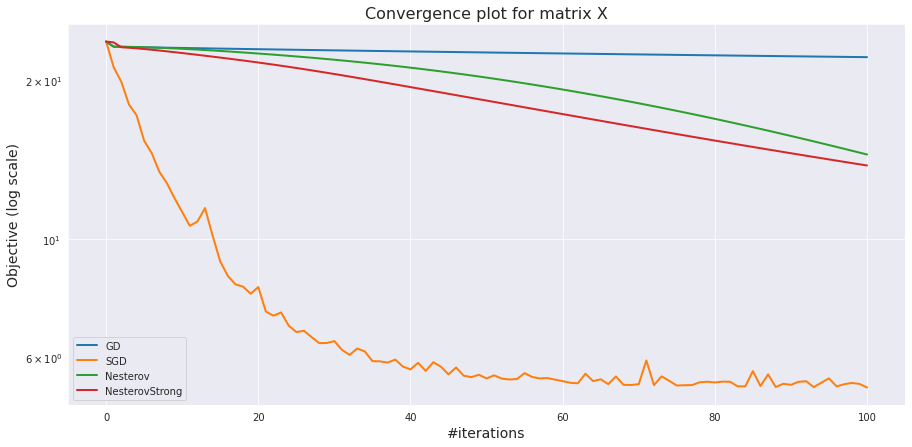

In [ ]:
# Implementation - Compare both variants on 1 run
f, ax = plt.subplots(figsize=(15, 7))
plt.semilogy(obj_gd, label="GD", lw=2)
plt.semilogy(obj_sgd, label="SGD", lw=2)
plt.semilogy(obj_n, label="Nesterov", lw=2)
plt.semilogy(obj_ns, label="NesterovStrong", lw=2)
plt.title("Convergence plot for matrix X", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()

#2.5 ) Ridge Regularization

Regularization is obtained by introducing a penalty. It is often called ridge regression, and is defined as 
$$
\min_x  ||XW-y||^2 + \lambda ||W||^2
$$

where $\lambda > 0$ is the regularization parameter.

In [ ]:
X_train_norm = (X_train-X_train.min())/(X_train.max()-X_train.min())

In [ ]:
X,y= np.array(X_train_norm), np.array(y_train)
X_val,y_val = np.array(X_test), np.array(y_test)

In [ ]:
y=y-y.mean()

In [ ]:
Lambda = .2*np.linalg.norm(X)**2;
w = np.linalg.solve(X.transpose().dot(X) + Lambda*np.eye(d), X.transpose().dot(y))

In [ ]:
norm(X.dot(w)-y)

770.8191874618317

In [ ]:
props=[0.001,0.002,0.005,0.01,0.02, 0.05 , 0.1,0.05]
ws = [np.linalg.solve(X.transpose().dot(X) + (l*np.linalg.norm(X)**2)*np.eye(d), X.transpose().dot(y)) for l in props]

errs= [norm(X.dot(w)-y) for w in ws]

Text(0, 0.5, 'Error')

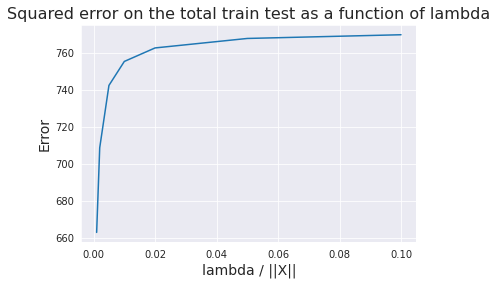

In [ ]:
plt.plot(props,errs)
plt.title("Squared error on the total train test as a function of lambda", fontsize=16)
plt.xlabel("lambda / ||X||", fontsize=14)
plt.ylabel("Error", fontsize=14)

In [ ]:
pblinreg_ridge = RegPb(X, y,loss='l2',lbda=0.01)

w_init = np.random.rand(d)
# Compute the optimal solution for linear regression
w_min_lin, f_min_lin, _ = fmin_l_bfgs_b(pblinreg_ridge.fun, w_init, pblinreg_ridge.grad, args=(), pgtol=1e-30, factr =1e-30)
print(f_min_lin)
print(norm(pblinreg_ridge.grad(w_min_lin)))

19.010135071946898
8.53895105559565e-08


In [ ]:
nb_epochs = 100
n = pblinreg_ridge.n
w0 = np.random.rand(d)

start_time = time.time()
# Run a - Gradient descent with constant stepsize
w_a, obj_a, nits_a = stoch_grad(w0,pblinreg_ridge,w_min_lin,stepchoice=0,step0=1, n_iter=nb_epochs,nb=n)

print("--- %s minutes ---" % ((time.time() - start_time)/60))

start_time = time.time()
# Run b - Stochastic gradient with constant stepsize
# The version below may diverges, in which case the bound on norm(w) in the code will be triggered
w_b, obj_b, nits_b = stoch_grad(w0,pblinreg_ridge,w_min_lin,stepchoice=0,step0=1, n_iter=int(nb_epochs*n),nb=1)
print("--- %s minutes ---" % ((time.time() - start_time)/60))

start_time = time.time()
# Run Stochastic gradient with decreasing stepsize
w_c, obj_c, nits_c = stoch_grad(w0,pblinreg_ridge,w_min_lin,stepchoice=0.5,step0=0.2, n_iter=nb_epochs*n,nb=1)
print("--- %s minutes ---" % ((time.time() - start_time)/60))

Stochastic Gradient, batch size= 12907 / 12907
  iter   |   fval   |  normit 
       0 | 7.26e+01 | 2.53e+01
       1 | 2.33e+01 | 2.51e+01
       2 | 2.33e+01 | 2.50e+01
       3 | 2.32e+01 | 2.50e+01
       4 | 2.32e+01 | 2.50e+01
       5 | 2.32e+01 | 2.50e+01
       6 | 2.32e+01 | 2.49e+01
       7 | 2.32e+01 | 2.49e+01
       8 | 2.32e+01 | 2.49e+01
       9 | 2.32e+01 | 2.48e+01
      10 | 2.31e+01 | 2.48e+01
      11 | 2.31e+01 | 2.48e+01
      12 | 2.31e+01 | 2.48e+01
      13 | 2.31e+01 | 2.47e+01
      14 | 2.31e+01 | 2.47e+01
      15 | 2.31e+01 | 2.47e+01
      16 | 2.31e+01 | 2.46e+01
      17 | 2.31e+01 | 2.46e+01
      18 | 2.31e+01 | 2.46e+01
      19 | 2.30e+01 | 2.46e+01
      20 | 2.30e+01 | 2.45e+01
      21 | 2.30e+01 | 2.45e+01
      22 | 2.30e+01 | 2.45e+01
      23 | 2.30e+01 | 2.44e+01
      24 | 2.30e+01 | 2.44e+01
      25 | 2.30e+01 | 2.44e+01
      26 | 2.30e+01 | 2.44e+01
      27 | 2.29e+01 | 2.43e+01
      28 | 2.29e+01 | 2.43e+01
      29 | 2.29e+01 | 2

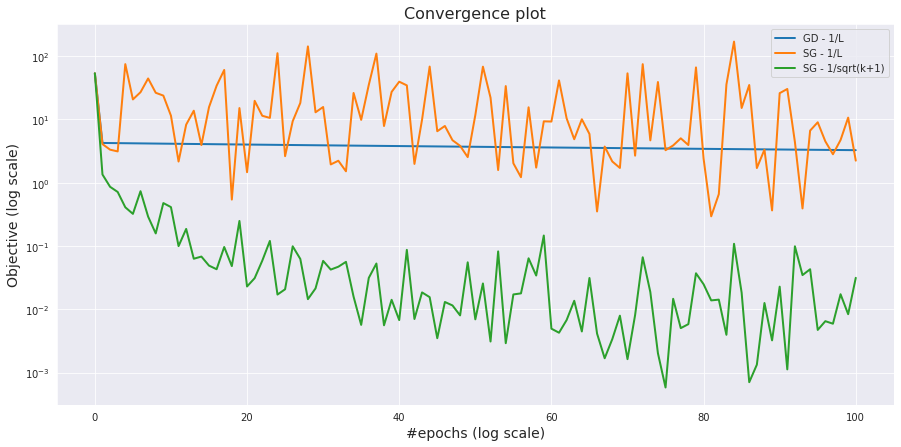

In [ ]:
# Plot the comparison of variants of GD/SG with the same stepsize rule
# NB: The x-axis is in epochs (1 iteration of GD).

# In terms of objective value (logarithmic scale)
f, ax = plt.subplots(figsize=(15, 7))
plt.semilogy(obj_a-f_min_lin, label="GD - 1/L", lw=2)
plt.semilogy(obj_b-f_min_lin, label="SG - 1/L", lw=2)
plt.semilogy(obj_c-f_min_lin, label="SG - 1/sqrt(k+1)", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()